In [1]:
import numpy as np # for random number distributions
import pandas as pd # for event_log data frame
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 10)
import queue # add FIFO queue data structure
from functools import partial, wraps
import random
import simpy # discrete event simulation %environment
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

### Global Variables

In [2]:
# Raw Materials
RM_Order_Qty = 300 # units
RM_Order_Time = 30 # days
RM_Max = 450 # units

# Production
Prod_Speed = 10 # units per day per machine # assume set speed, no variation
Least_Efficiency = 8 # worst-case scenario of min number of units per day
Prod_Machine = 1 # can vary from 1 to 3

# Finished Goods
FG_Max = 100 # units
Delivery = 10 # units / day / door # assume set speed, no variation
Doors = 1 # can vary from 1 to 3

# Customers
Cust_Orders = 10 # orders / day
Order_Max = 15 # balking tolerance
Wait_Max = 2 # days

obtain_reproducible_results = True

simulation_days = 365 
fixed_simulation_time = simulation_days * 24

In [3]:
'''        
---------------------------------------------------------
set up event tracing of all simulation program events 
controlled by the simulation environment
that is, all timeout and process events that begin with "env."
documentation at:
  https://simpy.readthedocs.io/en/latest/topical_guides/monitoring.html#event-tracing
  https://docs.python.org/3/library/functools.html#functools.partial
'''
def trace(env, callback):
     """Replace the ``step()`` method of *env* with a tracing function
     that calls *callbacks* with an events time, priority, ID and its
     instance just before it is processed.
     note: "event" here refers to simulaiton program events

     """
     def get_wrapper(env_step, callback):
         """Generate the wrapper for env.step()."""
         @wraps(env_step)
         def tracing_step():
             """Call *callback* for the next event if one exist before
             calling ``env.step()``."""
             if len(env._queue):
                 t, prio, eid, event = env._queue[0]
                 callback(t, prio, eid, event)
             return env_step()
         return tracing_step

     env.step = get_wrapper(env.step, callback)

def trace_monitor(data, t, prio, eid, event):
     data.append((t, eid, type(event)))

def test_process(env):
     yield env.timeout(1)

'''
---------------------------------------------------------
set up an event log for recording events
as defined for the discrete event simulation
we use a list of tuples for the event log
documentation at:
  https://simpy.readthedocs.io/en/latest/topical_guides/monitoring.html#event-tracing
'''

def event_log_append(env, rmid, orderid, time, activity, event_log, order_queue, rm_inv=None, fg_inv=None):
    event_log.append((rmid, orderid, time, activity, rm_inv, fg_inv, order_queue.qsize()))
    yield env.timeout(0)
    


In [4]:
# returns real number of minutes
def random_order_time(Cust_Orders) :
    try_order_time = np.random.normal(loc = 24/Cust_Orders, scale = 1)
    if (try_order_time < 0):
        return(0)
    if (try_order_time > 2 * 24/Cust_Orders):
        return(2 * 24/Cust_Orders)
    if (try_order_time >= 0) and (try_order_time <= 2 * 24/Cust_Orders):
        return(try_order_time)

def RM(env, RM_ID, RM_inv, FG_inv, event_log, order_queue):
    while True:
        print(f'Day {env.now}: {RM_Order_Qty} of Raw Materials units arriving in {RM_Order_Time} days \n')
        yield env.timeout(RM_Order_Time)
        RM_ID += 1
        time = env.now
        activity = 'Raw Materials arrival'
        env.process(event_log_append(
            env,RM_ID, None, time, activity, event_log,order_queue,rm_inv=RM_inv.level,fg_inv=FG_inv.level))
        yield env.timeout(0)
        if RM_inv.level + RM_Order_Qty < RM_inv.capacity:
            RM_inv.put(RM_Order_Qty)
            print(f'Accepted RM order# {RM_ID} @ {env.now}')
            time = env.now
            activity = 'Raw Materials put in storage'
            env.process(event_log_append(
                env,RM_ID, None, time, activity, event_log,order_queue,rm_inv=RM_inv.level,fg_inv=FG_inv.level)) 
        else:
            print(f'Rejected RM order# {RM_ID} @ {env.now}')
            time = env.now
            activity = 'Raw Materials rejected'
            env.process(event_log_append(
                env,RM_ID, None, time, activity, event_log,order_queue,rm_inv=RM_inv.level,fg_inv=FG_inv.level)) 

def prod(env, RM_inv, FG_inv, event_log, order_queue):
    while True:
        print(f"Start production for day {env.now}...")
        fg_yield = random.randint(Least_Efficiency, Prod_Speed)
        if RM_inv.level - Prod_Speed * Prod_Machine >= 0 and FG_inv.level + fg_yield * Prod_Machine <= FG_inv.capacity:
            print(f"{fg_yield * Prod_Machine} units produced on day {env.now}\n")
            RM_inv.get(Prod_Speed * Prod_Machine)
            FG_inv.put(fg_yield * Prod_Machine)
        else:
            print(f"0 units produced (insufficienct inventory/capacity) on day {env.now}\n")
            print('End Production.')
        yield env.timeout(1)
        time = env.now
        activity = 'Finished goods production completion'
        env.process(event_log_append(
            env,None, None, time, activity, event_log,order_queue,rm_inv=RM_inv.level,fg_inv=FG_inv.level)) 
        yield env.timeout(0)

def inv_report(env, RM_inv, FG_inv, event_log, order_queue):
    while True:
        print(f"Day {env.now}: \n\tRaw Materials Inventory = {RM_inv.level}")
        print(f"\tFinished Goods Inventory = {FG_inv.level}\n")
        time = env.now
        activity = 'inventory report'
        env.process(event_log_append(
            env,None, None, time, activity, event_log,order_queue,rm_inv=RM_inv.level,fg_inv=FG_inv.level)) 
        yield env.timeout(1)

def order(env, orderid, order_queue, RM_inv, FG_inv, event_log):
    while True:
        next_order_time = random_order_time(Cust_Orders)/24 #converting hours to days
        yield env.timeout(next_order_time)
        orderid += 1
        time = env.now
        activity = 'order process started'
        env.process(event_log_append(
            env,None, orderid, time, activity, event_log,order_queue,rm_inv=RM_inv.level,fg_inv=FG_inv.level)) 
        yield env.timeout(0)
        if order_queue.qsize() < Order_Max:
            order_queue.put(orderid)
            print(f"Order# {orderid} placed @ {round(env.now,2)} \n\t Order queue length = {order_queue.qsize()}")
            time = env.now
            activity = 'order placed'
            env.process(event_log_append(
                env,None, orderid, time, activity, event_log,order_queue,rm_inv=RM_inv.level,fg_inv=FG_inv.level)) 
            env.process(fulfillment(env,order_queue, RM_inv, FG_inv, event_log))
        else:
            print(f"Order# {orderid} not placed @ {round(env.now,2)} \n\t Order queue length = {order_queue.qsize()}")
            time = env.now
            activity = 'order not placed'
            env.process(event_log_append(
                env,None, orderid, time, activity, event_log,order_queue,rm_inv=RM_inv.level,fg_inv=FG_inv.level)) 

def fulfillment(env,order_queue, RM_inv, FG_inv, event_log):
    with available_doors.request() as req:
        yield req  # wait until the request can be met.. there must be an available door
        orderid = order_queue.get()
        while FG_inv.level <= 0:
            # just want to 'peek' at front of queue by using .queue[0]
            # .get() will take out the item in front of the queue...!
            print(f"Begin fulfillment of order# {orderid}") 
            print(f"Stop fulliment of order# {orderid} (insufficient FG inventory)\n") 
            time = env.now
            activity = 'fulfillment - insufficient inventory - wait'
            env.process(event_log_append(
                env,None, orderid, time, activity, event_log,order_queue,rm_inv=RM_inv.level,fg_inv=FG_inv.level)) 
            yield env.timeout(1) # skip the day/check tomorrow if inventory is empty...?            
        else:
            FG_inv.get(1)
            print(f"Begin fulfillment of order# {orderid}") 
            print(f"Loading  order# {orderid} @ {round(env.now,3)}; order queue length = {order_queue.qsize()}\n")
            time = env.now
            Loading = random.uniform(1/24, 3/24) # loading anywhere between 1 and 3 hours
            env.process(event_log_append(
                env,None, orderid, env.now, 'fulfillment - begin loading', event_log,order_queue,
                rm_inv=RM_inv.level,fg_inv=FG_inv.level)) 
            yield env.timeout(Loading)  # sets generator function
            queue_length_post_loading = order_queue.qsize()
            print(f"Finished loading order# {orderid} @ {round(env.now,3)}; order queue length = {queue_length_post_loading}\n")
            env.process(event_log_append(
                env,None, orderid, env.now, 'fulfillment - finish loading', event_log,order_queue,
                rm_inv=RM_inv.level,fg_inv=FG_inv.level))


# Simulation #1:

In [5]:
parameter_string_list = [str(simulation_days),'days',
              str(RM_Order_Qty),str(RM_Order_Time),
              str(RM_Max),str(Prod_Machine),
              str(FG_Max),str(Doors),
              str(Cust_Orders),str(Order_Max),
              str(Wait_Max)]
separator = '-'        
simulation_file_identifier = separator.join(parameter_string_list)

if obtain_reproducible_results: 
    np.random.seed(12345)

# set up simulation trace monitoring for the simulation
data = []
# bind *data* as first argument to monitor()
this_trace_monitor = partial(trace_monitor, data)

env = simpy.Environment()
trace(env, this_trace_monitor)

order_queue = queue.Queue()
available_doors = simpy.Resource(env, Doors)
RM_inv = simpy.Container(env, capacity = RM_Max, init = 300)
FG_inv = simpy.Container(env, capacity = FG_Max, init = 0)

event_log = [(0,0,0,'init',RM_inv.level,FG_inv.level, 0)]
env.process(event_log_append(env, 0, 0, env.now, 'start simulation', event_log, order_queue,
                             RM_inv.level,FG_inv.level))
env.process(inv_report(env, RM_inv, FG_inv, event_log, order_queue))
env.process(RM(env, 0, RM_inv, FG_inv, event_log, order_queue))
env.process(prod(env, RM_inv, FG_inv, event_log, order_queue))
env.process(order(env, 0, order_queue, RM_inv, FG_inv, event_log))
env.run(until = 365)

Day 0: 
	Raw Materials Inventory = 300
	Finished Goods Inventory = 0

Day 0: 300 of Raw Materials units arriving in 30 days 

Start production for day 0...
9 units produced on day 0

Order# 1 placed @ 0.09 
	 Order queue length = 1
Begin fulfillment of order# 1
Loading  order# 1 @ 0.091; order queue length = 0

Finished loading order# 1 @ 0.206; order queue length = 0

Order# 2 placed @ 0.21 
	 Order queue length = 1
Begin fulfillment of order# 2
Loading  order# 2 @ 0.211; order queue length = 0

Order# 3 placed @ 0.29 
	 Order queue length = 1
Finished loading order# 2 @ 0.304; order queue length = 1

Begin fulfillment of order# 3
Loading  order# 3 @ 0.304; order queue length = 0

Order# 4 placed @ 0.37 
	 Order queue length = 1
Finished loading order# 3 @ 0.402; order queue length = 1

Begin fulfillment of order# 4
Loading  order# 4 @ 0.402; order queue length = 0

Finished loading order# 4 @ 0.472; order queue length = 0

Order# 5 placed @ 0.55 
	 Order queue length = 1
Begin fulfil

Start production for day 59...
10 units produced on day 59

Order# 594 placed @ 59.03 
	 Order queue length = 12
Finished loading order# 579 @ 59.092; order queue length = 12

Begin fulfillment of order# 583
Loading  order# 583 @ 59.092; order queue length = 11

Order# 595 placed @ 59.14 
	 Order queue length = 12
Finished loading order# 583 @ 59.18; order queue length = 12

Begin fulfillment of order# 584
Loading  order# 584 @ 59.18; order queue length = 11

Finished loading order# 584 @ 59.234; order queue length = 11

Begin fulfillment of order# 585
Loading  order# 585 @ 59.234; order queue length = 10

Order# 596 placed @ 59.24 
	 Order queue length = 11
Finished loading order# 585 @ 59.288; order queue length = 11

Begin fulfillment of order# 586
Loading  order# 586 @ 59.288; order queue length = 10

Order# 597 placed @ 59.36 
	 Order queue length = 11
Finished loading order# 586 @ 59.401; order queue length = 11

Begin fulfillment of order# 587
Loading  order# 587 @ 59.401; order

Order# 1086 not placed @ 107.98 
	 Order queue length = 15
Finished loading order# 1063 @ 107.988; order queue length = 15

Begin fulfillment of order# 1064
Loading  order# 1064 @ 107.988; order queue length = 14

Day 108: 
	Raw Materials Inventory = 120
	Finished Goods Inventory = 6

Start production for day 108...
10 units produced on day 108

Order# 1087 placed @ 108.07 
	 Order queue length = 15
Finished loading order# 1064 @ 108.074; order queue length = 15

Begin fulfillment of order# 1065
Loading  order# 1065 @ 108.074; order queue length = 14

Finished loading order# 1065 @ 108.156; order queue length = 14

Begin fulfillment of order# 1066
Loading  order# 1066 @ 108.156; order queue length = 13

Order# 1088 placed @ 108.17 
	 Order queue length = 14
Order# 1089 placed @ 108.19 
	 Order queue length = 15
Finished loading order# 1066 @ 108.276; order queue length = 15

Begin fulfillment of order# 1067
Loading  order# 1067 @ 108.276; order queue length = 14

Order# 1090 placed @ 1

Start production for day 156...
10 units produced on day 156

Finished loading order# 1556 @ 156.046; order queue length = 10

Begin fulfillment of order# 1557
Loading  order# 1557 @ 156.046; order queue length = 9

Order# 1567 placed @ 156.08 
	 Order queue length = 10
Finished loading order# 1557 @ 156.129; order queue length = 10

Begin fulfillment of order# 1558
Loading  order# 1558 @ 156.129; order queue length = 9

Order# 1568 placed @ 156.18 
	 Order queue length = 10
Finished loading order# 1558 @ 156.193; order queue length = 10

Begin fulfillment of order# 1559
Loading  order# 1559 @ 156.193; order queue length = 9

Order# 1569 placed @ 156.28 
	 Order queue length = 10
Finished loading order# 1559 @ 156.3; order queue length = 10

Begin fulfillment of order# 1560
Loading  order# 1560 @ 156.3; order queue length = 9

Finished loading order# 1560 @ 156.353; order queue length = 9

Begin fulfillment of order# 1561
Loading  order# 1561 @ 156.353; order queue length = 8

Order# 1

Loading  order# 2124 @ 214.53; order queue length = 13

Order# 2146 placed @ 214.61 
	 Order queue length = 14
Finished loading order# 2124 @ 214.619; order queue length = 14

Begin fulfillment of order# 2125
Loading  order# 2125 @ 214.619; order queue length = 13

Order# 2147 placed @ 214.67 
	 Order queue length = 14
Finished loading order# 2125 @ 214.683; order queue length = 14

Begin fulfillment of order# 2126
Loading  order# 2126 @ 214.683; order queue length = 13

Finished loading order# 2126 @ 214.747; order queue length = 13

Begin fulfillment of order# 2127
Loading  order# 2127 @ 214.747; order queue length = 12

Finished loading order# 2127 @ 214.812; order queue length = 12

Begin fulfillment of order# 2128
Loading  order# 2128 @ 214.812; order queue length = 11

Order# 2148 placed @ 214.82 
	 Order queue length = 12
Finished loading order# 2128 @ 214.855; order queue length = 12

Begin fulfillment of order# 2129
Loading  order# 2129 @ 214.855; order queue length = 11

Orde


Start production for day 263...
9 units produced on day 263

Finished loading order# 2622 @ 263.025; order queue length = 7

Begin fulfillment of order# 2623
Loading  order# 2623 @ 263.025; order queue length = 6

Order# 2630 placed @ 263.04 
	 Order queue length = 7
Finished loading order# 2623 @ 263.142; order queue length = 7

Begin fulfillment of order# 2624
Loading  order# 2624 @ 263.142; order queue length = 6

Order# 2631 placed @ 263.15 
	 Order queue length = 7
Finished loading order# 2624 @ 263.188; order queue length = 7

Begin fulfillment of order# 2625
Loading  order# 2625 @ 263.188; order queue length = 6

Finished loading order# 2625 @ 263.265; order queue length = 6

Begin fulfillment of order# 2626
Loading  order# 2626 @ 263.265; order queue length = 5

Order# 2632 placed @ 263.29 
	 Order queue length = 6
Order# 2633 placed @ 263.36 
	 Order queue length = 7
Finished loading order# 2626 @ 263.359; order queue length = 7

Begin fulfillment of order# 2627
Loading  orde

Finished loading order# 3210 @ 324.073; order queue length = 13

Begin fulfillment of order# 3211
Loading  order# 3211 @ 324.073; order queue length = 12

Finished loading order# 3211 @ 324.146; order queue length = 12

Begin fulfillment of order# 3212
Loading  order# 3212 @ 324.146; order queue length = 11

Order# 3224 placed @ 324.18 
	 Order queue length = 12
Finished loading order# 3212 @ 324.202; order queue length = 12

Begin fulfillment of order# 3213
Loading  order# 3213 @ 324.202; order queue length = 11

Finished loading order# 3213 @ 324.253; order queue length = 11

Begin fulfillment of order# 3214
Loading  order# 3214 @ 324.253; order queue length = 10

Order# 3225 placed @ 324.31 
	 Order queue length = 11
Finished loading order# 3214 @ 324.329; order queue length = 11

Begin fulfillment of order# 3215
Loading  order# 3215 @ 324.329; order queue length = 10

Finished loading order# 3215 @ 324.442; order queue length = 10

Begin fulfillment of order# 3216
Loading  order# 3

In [6]:
simulation_trace_file_name = 'simulation-program-trace-' + simulation_file_identifier + '.txt'
with open(simulation_trace_file_name, 'wt') as ftrace:
    for d in data:
        print(str(d), file = ftrace)

print()        
print('simulation program trace written to file:',simulation_trace_file_name)

event_log_list = [list(element) for element in event_log]
event_log_df = pd.DataFrame(event_log_list,columns = ['rm_id','order_id','time','activity','rm_inventory','fg_inventory','order_queue_size'])
event_log_file_name = 'simulation-event-log-' + simulation_file_identifier + '.csv'
event_log_df.to_csv(event_log_file_name, index = False)  

print()        
print('simulation program trace written to file:',event_log_file_name)


simulation program trace written to file: simulation-program-trace-365-days-300-30-450-1-100-1-10-15-2.txt

simulation program trace written to file: simulation-event-log-365-days-300-30-450-1-100-1-10-15-2.csv


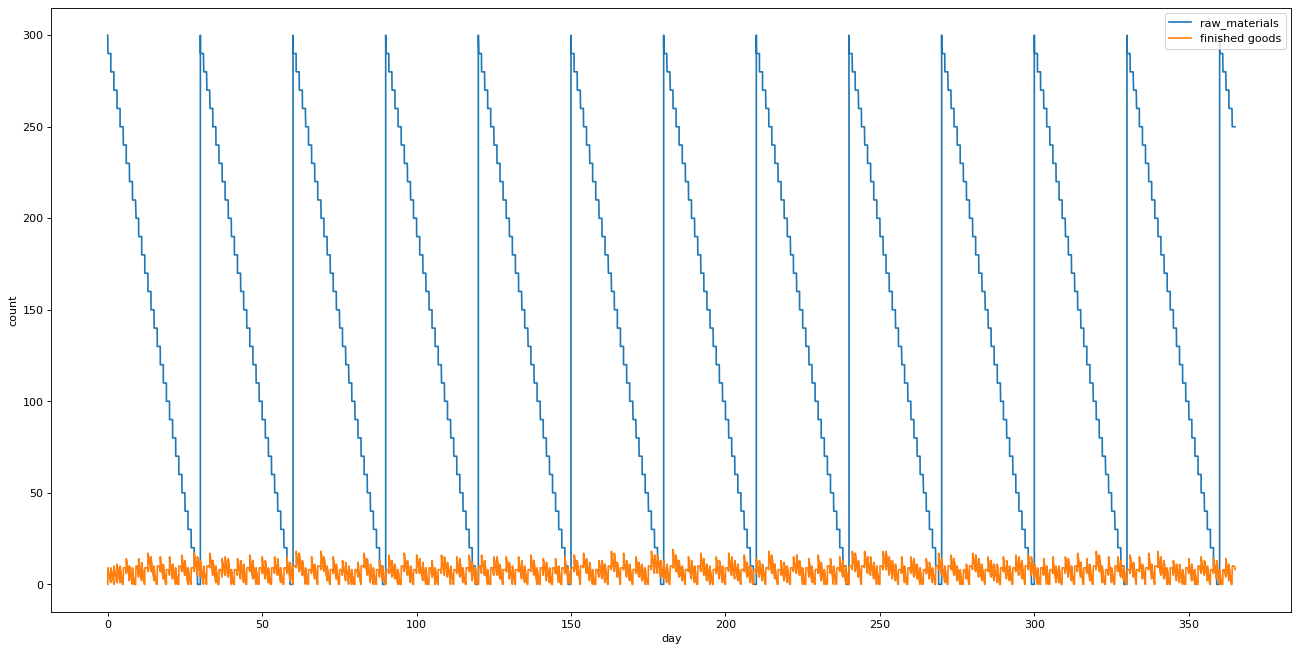

In [7]:
figure(figsize = (20, 10), dpi = 80)
plt.plot(event_log_df.time, event_log_df.rm_inventory, label='raw_materials')
plt.plot(event_log_df.time, event_log_df.fg_inventory, label='finished goods')
plt.ylabel('count')
plt.xlabel('day')
plt.legend()
plt.show()

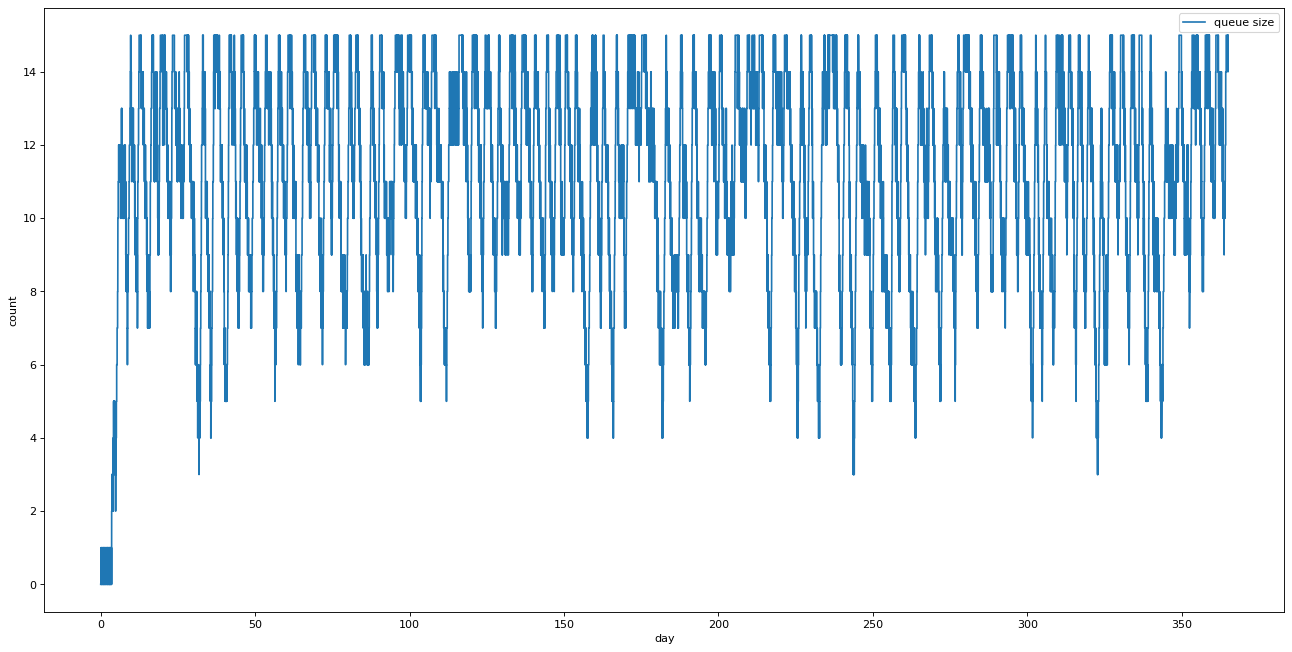

In [8]:
figure(figsize = (20, 10), dpi = 80)
plt.plot(event_log_df.time, event_log_df.order_queue_size, label='queue size')
plt.ylabel('count')
plt.xlabel('day')
plt.legend()
plt.show()

In [9]:
event_log_df.groupby('activity').size()

activity
Finished goods production completion            364
Raw Materials arrival                            12
Raw Materials put in storage                     12
fulfillment - begin loading                    3276
fulfillment - finish loading                   3275
fulfillment - insufficient inventory - wait      90
init                                              1
inventory report                                365
order not placed                                345
order placed                                   3291
order process started                          3636
start simulation                                  1
dtype: int64

In [10]:
order_time_log = []

ffinish_load_df = event_log_df[(event_log_df['activity'] == 'fulfillment - finish loading')]

for index, row in ffinish_load_df.iterrows():
    order_id = row.order_id
    end = row.time
    start_row = event_log_df[(event_log_df['order_id'] == order_id) & (event_log_df['activity'] == 'order placed')]
    start = start_row.time.values[0]
    duration = end - start
    order_time_log.append((int(order_id), start, end, duration))

order_time_log_list = [list(element) for element in order_time_log]
order_time_log_df = pd.DataFrame(order_time_log_list,columns = ['order_id','start','stop','duration'])

# avg order duration
order_time_log_df.duration.mean()

1.353554409716781

# Simulation # 2 (increase # of doors):

In [11]:
Doors = 2

In [12]:
parameter_string_list = [str(simulation_days),'days',
              str(RM_Order_Qty),str(RM_Order_Time),
              str(RM_Max),str(Prod_Machine),
              str(FG_Max),str(Doors),
              str(Cust_Orders),str(Order_Max),
              str(Wait_Max)]
separator = '-'        
simulation_file_identifier = separator.join(parameter_string_list)

if obtain_reproducible_results: 
    np.random.seed(12345)

# set up simulation trace monitoring for the simulation
data = []
# bind *data* as first argument to monitor()
this_trace_monitor = partial(trace_monitor, data)

env = simpy.Environment()
trace(env, this_trace_monitor)

order_queue = queue.Queue()
available_doors = simpy.Resource(env, Doors)
RM_inv = simpy.Container(env, capacity = RM_Max, init = 300)
FG_inv = simpy.Container(env, capacity = FG_Max, init = 0)

event_log = [(0,0,0,'init',RM_inv.level,FG_inv.level, 0)]
env.process(event_log_append(env, 0, 0, env.now, 'start simulation', event_log, order_queue,
                             RM_inv.level,FG_inv.level))
env.process(inv_report(env, RM_inv, FG_inv, event_log, order_queue))
env.process(RM(env, 0, RM_inv, FG_inv, event_log, order_queue))
env.process(prod(env, RM_inv, FG_inv, event_log, order_queue))
env.process(order(env, 0, order_queue, RM_inv, FG_inv, event_log))
env.run(until = 365)

Day 0: 
	Raw Materials Inventory = 300
	Finished Goods Inventory = 0

Day 0: 300 of Raw Materials units arriving in 30 days 

Start production for day 0...
8 units produced on day 0

Order# 1 placed @ 0.09 
	 Order queue length = 1
Begin fulfillment of order# 1
Loading  order# 1 @ 0.091; order queue length = 0

Finished loading order# 1 @ 0.182; order queue length = 0

Order# 2 placed @ 0.21 
	 Order queue length = 1
Begin fulfillment of order# 2
Loading  order# 2 @ 0.211; order queue length = 0

Finished loading order# 2 @ 0.264; order queue length = 0

Order# 3 placed @ 0.29 
	 Order queue length = 1
Begin fulfillment of order# 3
Loading  order# 3 @ 0.29; order queue length = 0

Order# 4 placed @ 0.37 
	 Order queue length = 1
Begin fulfillment of order# 4
Loading  order# 4 @ 0.367; order queue length = 0

Finished loading order# 3 @ 0.41; order queue length = 0

Finished loading order# 4 @ 0.415; order queue length = 0

Order# 5 placed @ 0.55 
	 Order queue length = 1
Begin fulfillm

Finished loading order# 512 @ 52.932; order queue length = 15

Begin fulfillment of order# 514
Loading  order# 514 @ 52.932; order queue length = 14

Order# 534 placed @ 52.94 
	 Order queue length = 15
Finished loading order# 514 @ 52.998; order queue length = 15

Begin fulfillment of order# 515
Loading  order# 515 @ 52.998; order queue length = 14

Day 53: 
	Raw Materials Inventory = 70
	Finished Goods Inventory = 5

Start production for day 53...
8 units produced on day 53

Finished loading order# 513 @ 53.013; order queue length = 14

Begin fulfillment of order# 516
Loading  order# 516 @ 53.013; order queue length = 13

Order# 535 placed @ 53.06 
	 Order queue length = 14
Finished loading order# 515 @ 53.076; order queue length = 14

Begin fulfillment of order# 517
Loading  order# 517 @ 53.076; order queue length = 13

Finished loading order# 516 @ 53.113; order queue length = 13

Begin fulfillment of order# 518
Loading  order# 518 @ 53.113; order queue length = 12

Finished loadin


Begin fulfillment of order# 968
Loading  order# 968 @ 98.061; order queue length = 12

Finished loading order# 968 @ 98.112; order queue length = 12

Begin fulfillment of order# 969
Loading  order# 969 @ 98.112; order queue length = 11

Finished loading order# 967 @ 98.138; order queue length = 11

Begin fulfillment of order# 970
Loading  order# 970 @ 98.138; order queue length = 10

Order# 984 placed @ 98.15 
	 Order queue length = 11
Finished loading order# 969 @ 98.164; order queue length = 11

Begin fulfillment of order# 971
Loading  order# 971 @ 98.164; order queue length = 10

Finished loading order# 970 @ 98.206; order queue length = 10

Begin fulfillment of order# 972
Loading  order# 972 @ 98.206; order queue length = 9

Order# 985 placed @ 98.22 
	 Order queue length = 10
Finished loading order# 971 @ 98.236; order queue length = 10

Begin fulfillment of order# 973
Loading  order# 973 @ 98.236; order queue length = 9

Finished loading order# 972 @ 98.273; order queue length =

Loading  order# 1440 @ 144.021; order queue length = 9

Order# 1450 placed @ 144.03 
	 Order queue length = 10
Finished loading order# 1438 @ 144.048; order queue length = 10

Begin fulfillment of order# 1441
Loading  order# 1441 @ 144.048; order queue length = 9

Finished loading order# 1440 @ 144.112; order queue length = 9

Begin fulfillment of order# 1442
Loading  order# 1442 @ 144.112; order queue length = 8

Order# 1451 placed @ 144.12 
	 Order queue length = 9
Finished loading order# 1441 @ 144.165; order queue length = 9

Begin fulfillment of order# 1443
Loading  order# 1443 @ 144.165; order queue length = 8

Finished loading order# 1442 @ 144.201; order queue length = 8

Begin fulfillment of order# 1444
Loading  order# 1444 @ 144.201; order queue length = 7

Finished loading order# 1443 @ 144.227; order queue length = 7

Begin fulfillment of order# 1445
Loading  order# 1445 @ 144.227; order queue length = 6

Order# 1452 placed @ 144.25 
	 Order queue length = 7
Finished loadin

Begin fulfillment of order# 1887
Loading  order# 1887 @ 190.239; order queue length = 8

Finished loading order# 1886 @ 190.254; order queue length = 8

Begin fulfillment of order# 1888
Loading  order# 1888 @ 190.254; order queue length = 7

Order# 1899 placed @ 190.31 
	 Order queue length = 8
Finished loading order# 1888 @ 190.321; order queue length = 8

Begin fulfillment of order# 1889
Loading  order# 1889 @ 190.321; order queue length = 7

Finished loading order# 1887 @ 190.352; order queue length = 7

Begin fulfillment of order# 1890
Loading  order# 1890 @ 190.352; order queue length = 6

Finished loading order# 1889 @ 190.441; order queue length = 6

Begin fulfillment of order# 1891
Loading  order# 1891 @ 190.441; order queue length = 5

Order# 1900 placed @ 190.44 
	 Order queue length = 6
Finished loading order# 1890 @ 190.459; order queue length = 6

Begin fulfillment of order# 1892
Stop fulliment of order# 1892 (insufficient FG inventory)

Order# 1901 placed @ 190.5 
	 Order

Finished loading order# 2250 @ 226.621; order queue length = 11

Begin fulfillment of order# 2252
Loading  order# 2252 @ 226.621; order queue length = 10

Order# 2263 placed @ 226.65 
	 Order queue length = 11
Finished loading order# 2251 @ 226.652; order queue length = 11

Begin fulfillment of order# 2253
Loading  order# 2253 @ 226.652; order queue length = 10

Finished loading order# 2252 @ 226.663; order queue length = 10

Begin fulfillment of order# 2254
Loading  order# 2254 @ 226.663; order queue length = 9

Order# 2264 placed @ 226.7 
	 Order queue length = 10
Finished loading order# 2253 @ 226.745; order queue length = 10

Begin fulfillment of order# 2255
Loading  order# 2255 @ 226.745; order queue length = 9

Finished loading order# 2254 @ 226.771; order queue length = 9

Begin fulfillment of order# 2256
Loading  order# 2256 @ 226.771; order queue length = 8

Finished loading order# 2255 @ 226.798; order queue length = 8

Begin fulfillment of order# 2257
Loading  order# 2257 @ 


Finished loading order# 2726 @ 274.778; order queue length = 13

Begin fulfillment of order# 2728
Loading  order# 2728 @ 274.778; order queue length = 12

Order# 2742 placed @ 274.81 
	 Order queue length = 13
Finished loading order# 2727 @ 274.821; order queue length = 13

Begin fulfillment of order# 2729
Loading  order# 2729 @ 274.821; order queue length = 12

Finished loading order# 2728 @ 274.827; order queue length = 12

Begin fulfillment of order# 2730
Loading  order# 2730 @ 274.827; order queue length = 11

Finished loading order# 2729 @ 274.872; order queue length = 11

Begin fulfillment of order# 2731
Loading  order# 2731 @ 274.872; order queue length = 10

Finished loading order# 2730 @ 274.912; order queue length = 10

Begin fulfillment of order# 2732
Stop fulliment of order# 2732 (insufficient FG inventory)

Order# 2743 placed @ 274.97 
	 Order queue length = 10
Finished loading order# 2731 @ 274.994; order queue length = 10

Begin fulfillment of order# 2733
Stop fulliment

Loading  order# 3185 @ 321.092; order queue length = 10

Finished loading order# 3184 @ 321.127; order queue length = 10

Begin fulfillment of order# 3186
Loading  order# 3186 @ 321.127; order queue length = 9

Finished loading order# 3185 @ 321.15; order queue length = 9

Begin fulfillment of order# 3187
Loading  order# 3187 @ 321.15; order queue length = 8

Order# 3196 placed @ 321.19 
	 Order queue length = 9
Finished loading order# 3186 @ 321.25; order queue length = 9

Begin fulfillment of order# 3188
Loading  order# 3188 @ 321.25; order queue length = 8

Finished loading order# 3187 @ 321.268; order queue length = 8

Begin fulfillment of order# 3189
Loading  order# 3189 @ 321.268; order queue length = 7

Finished loading order# 3188 @ 321.312; order queue length = 7

Begin fulfillment of order# 3190
Loading  order# 3190 @ 321.312; order queue length = 6

Order# 3197 placed @ 321.35 
	 Order queue length = 7
Finished loading order# 3190 @ 321.365; order queue length = 7

Begin ful

In [13]:
simulation_trace_file_name = 'simulation-program-trace-' + simulation_file_identifier + '.txt'
with open(simulation_trace_file_name, 'wt') as ftrace:
    for d in data:
        print(str(d), file = ftrace)

print()        
print('simulation program trace written to file:',simulation_trace_file_name)

event_log_list = [list(element) for element in event_log]
event_log_df = pd.DataFrame(event_log_list,columns = ['rm_id','order_id','time','activity','rm_inventory','fg_inventory','order_queue_size'])
event_log_file_name = 'simulation-event-log-' + simulation_file_identifier + '.csv'
event_log_df.to_csv(event_log_file_name, index = False)  

print()        
print('simulation program trace written to file:',event_log_file_name)


simulation program trace written to file: simulation-program-trace-365-days-300-30-450-1-100-2-10-15-2.txt

simulation program trace written to file: simulation-event-log-365-days-300-30-450-1-100-2-10-15-2.csv


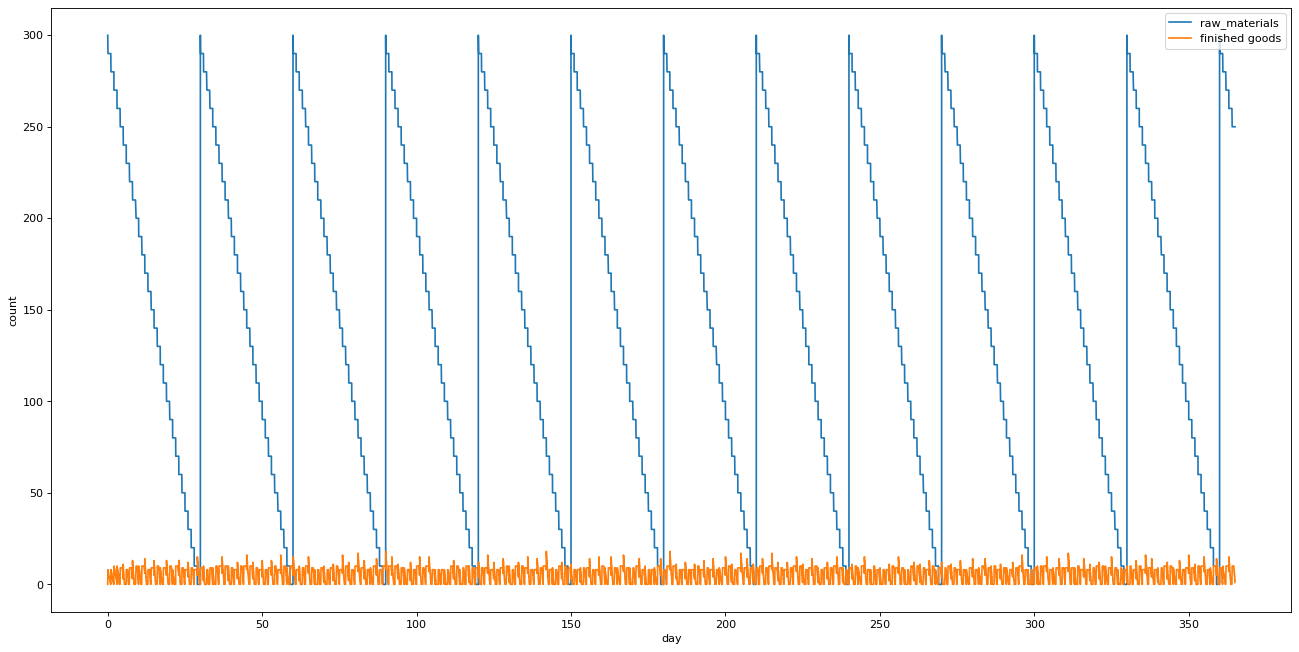

In [14]:
figure(figsize = (20, 10), dpi = 80)
plt.plot(event_log_df.time, event_log_df.rm_inventory, label='raw_materials')
plt.plot(event_log_df.time, event_log_df.fg_inventory, label='finished goods')
plt.ylabel('count')
plt.xlabel('day')
plt.legend()
plt.show()

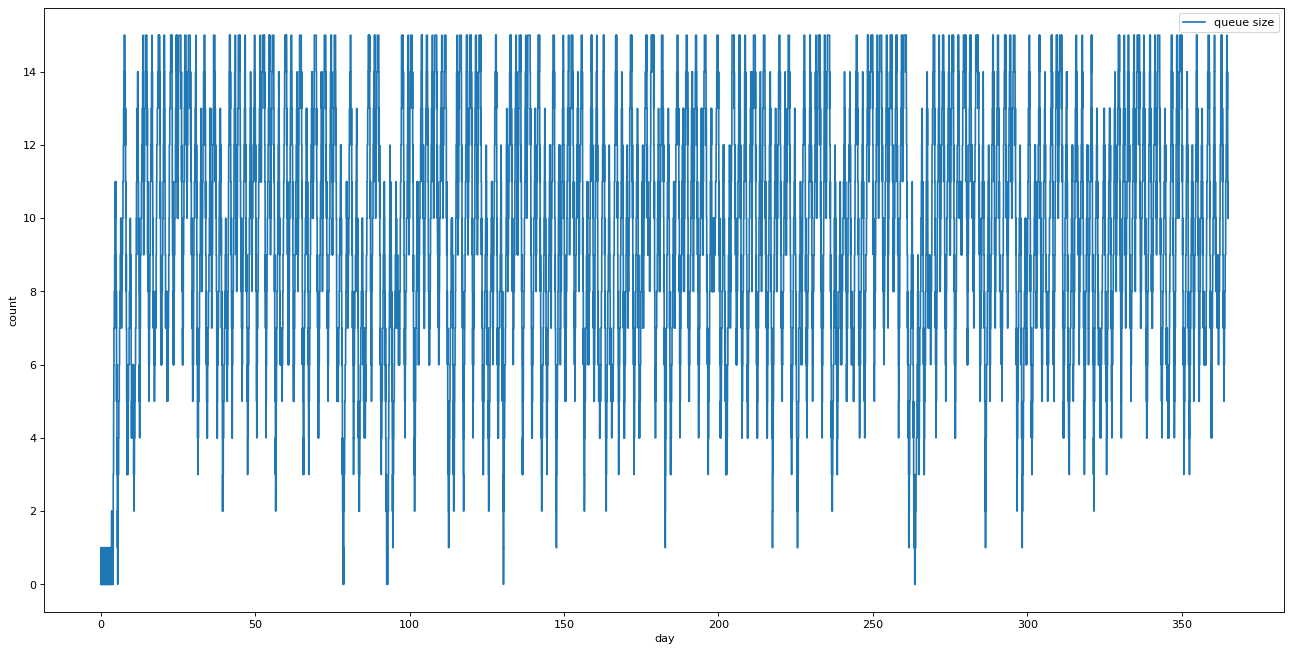

In [15]:
figure(figsize = (20, 10), dpi = 80)
plt.plot(event_log_df.time, event_log_df.order_queue_size, label='queue size')
plt.ylabel('count')
plt.xlabel('day')
plt.legend()
plt.show()

In [16]:
event_log_df.groupby('activity').size()

activity
Finished goods production completion            364
Raw Materials arrival                            12
Raw Materials put in storage                     12
fulfillment - begin loading                    3281
fulfillment - finish loading                   3279
fulfillment - insufficient inventory - wait     453
init                                              1
inventory report                                365
order not placed                                345
order placed                                   3291
order process started                          3636
start simulation                                  1
dtype: int64

In [17]:
order_time_log = []

ffinish_load_df = event_log_df[(event_log_df['activity'] == 'fulfillment - finish loading')]

for index, row in ffinish_load_df.iterrows():
    order_id = row.order_id
    end = row.time
    start_row = event_log_df[(event_log_df['order_id'] == order_id) & (event_log_df['activity'] == 'order placed')]
    start = start_row.time.values[0]
    duration = end - start
    order_time_log.append((int(order_id), start, end, duration))

order_time_log_list = [list(element) for element in order_time_log]
order_time_log_df = pd.DataFrame(order_time_log_list,columns = ['order_id','start','stop','duration'])

# avg order duration
order_time_log_df.duration.mean()

1.3035935044909928